In [16]:
%matplotlib inline
import sys                                 
import os                                  
import numpy as np                         
import matplotlib.pyplot as plt  
import pickle
from matplotlib.backends.backend_pdf import PdfPages
pp = PdfPages('distribution_of_codebook.pdf')                
                                           
caffe_root = os.environ["CAFFE_ROOT"]      
os.chdir(caffe_root)                       
print caffe_root                           
sys.path.insert(0, caffe_root + 'python')  
import caffe                               

/home/maohz12/pruning/


In [17]:
prototxt = '/home/maohz12/pruning/3_prototxt_solver/L2/train_val.prototxt'      
caffemodel = '/home/maohz12/pruning/4_model_checkpoint/alexnet/alexnet9x.caffemodel'    
# caffemodel = '/home/maohz12/pruning/4_model_checkpoint/bvlc_alexnet.caffemodel' 
dir_t = '/home/maohz12/pruning/2_results/kmeans/alexnet/'
codebook = pickle.load(open(dir_t + 'codebook.pkl'))
codebook_history = pickle.load(open(dir_t + 'codebook_history.pkl'))
codebook_4std = pickle.load(open(dir_t + 'codebook_4std.pkl'))
codebook_history_4std = pickle.load(open(dir_t + 'codebook_history_4std.pkl')) 
net = caffe.Net(prototxt, caffemodel, caffe.TEST)                                         

In [18]:
print codebook.keys()
# print codebook
for key in codebook.keys():
    print codebook[key].size

['fc6', 'fc7', 'fc8', 'conv3', 'conv2', 'conv1', 'conv5', 'conv4']
16
16
16
64
64
64
64
64


conv1


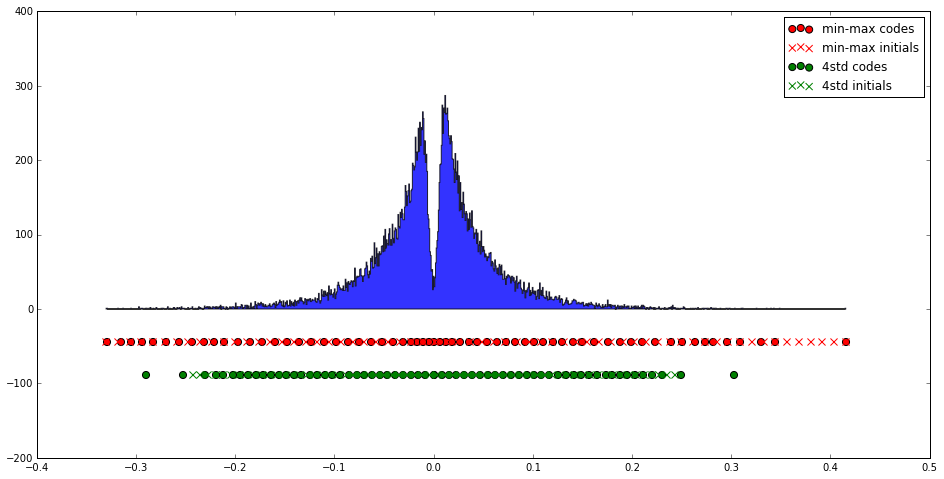

conv3


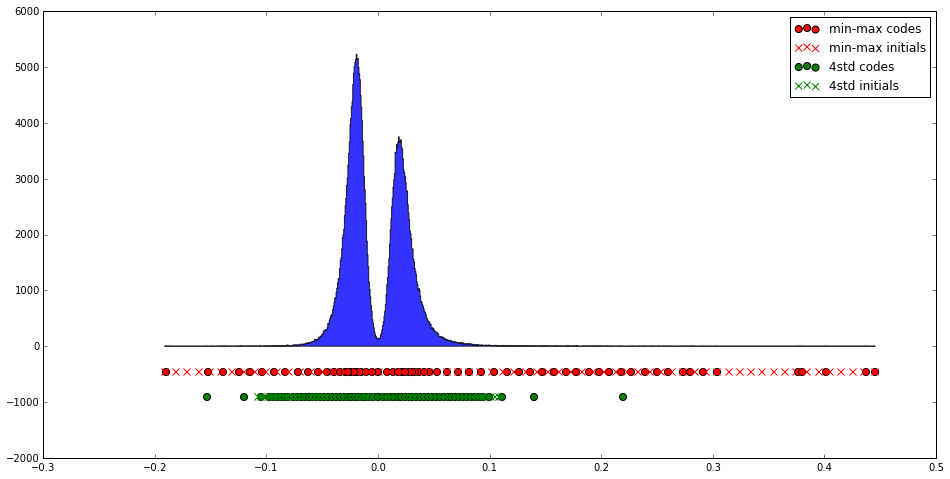

conv5


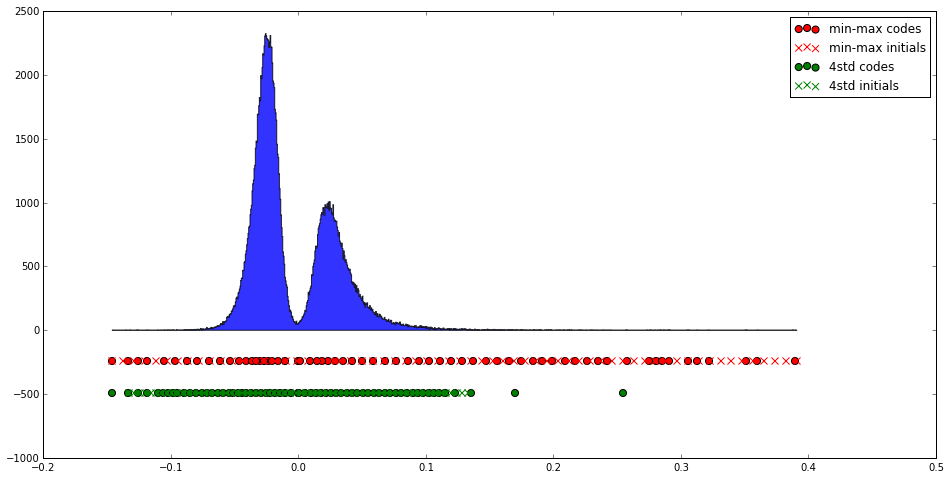

fc6


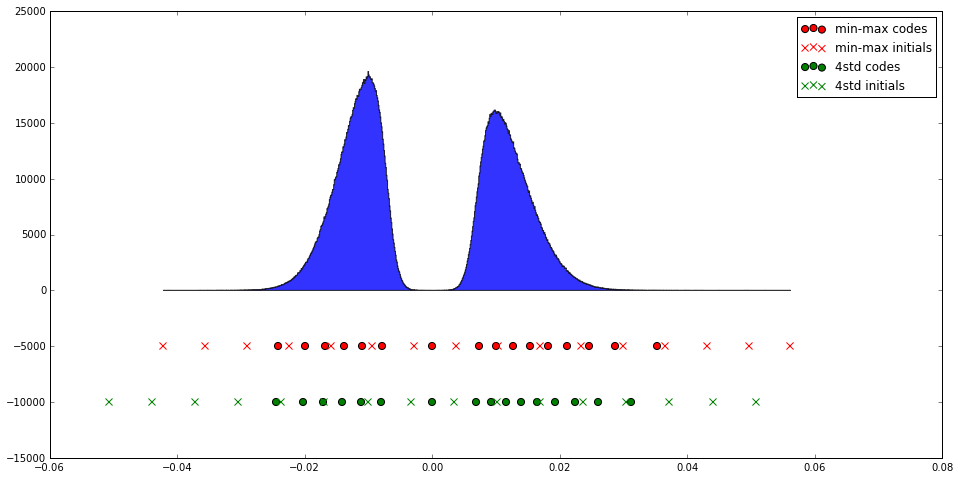

fc7


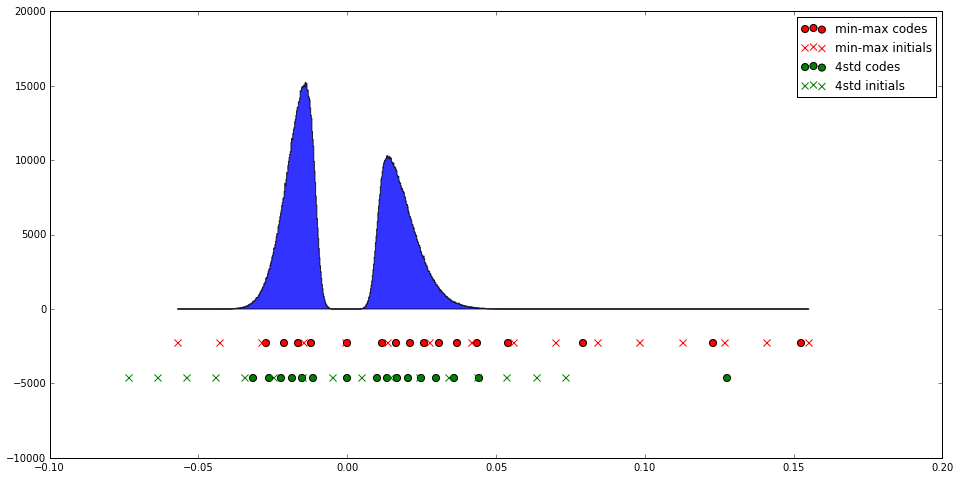

fc8


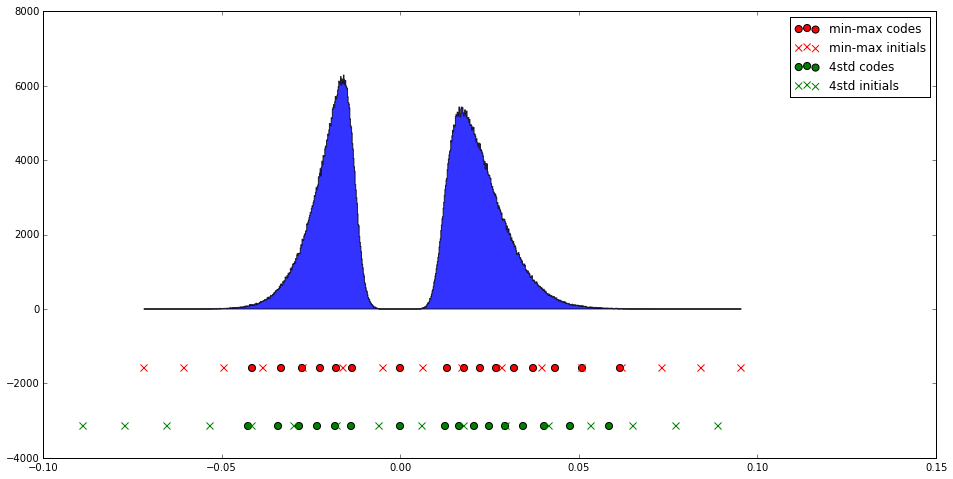

In [19]:

layers = filter(lambda x:'conv' in x or 'fc' in x, net.params.keys())
layers= ['conv1', 'conv3', 'conv5','fc6', 'fc7','fc8']

for i,layer in enumerate(layers):
    W = net.params[layer][0].data   
    W = W[np.where(W!=0)] 
   
    numBins = 1024  
    code = codebook[layer]
    min_W = np.min(W)                                       
    max_W = np.max(W)                
    num_c = 2**np.ceil(np.log2(code.size))
    initial_uni = np.linspace(min_W, max_W, num_c) 
    print layer
    plt.figure(figsize=(16,8))    
    # std = np.std(W)
    plt.hist(W.flatten(), numBins, color='blue', alpha=0.8, histtype='stepfilled') 
    shift = 0.0015 * W.size
    code_dot=plt.scatter(code, np.zeros(code.shape)-shift, marker='o', c='red', s=50)
    initial_cross=plt.scatter(initial_uni, np.zeros(initial_uni.shape)-shift, marker='x', c='red', s=50)
    
    # 4std
    W = net.params[layer][0].data   
    W = W[np.where(W!=0)] 
      
    code = codebook_4std[layer]

    std = np.std(W)          
    num_c = 2**np.ceil(np.log2(code.size))
    initial_uni = np.linspace(std * -4, std * 4, num_c)  
      
    # std = np.std(W)
    # plt.hist(W.flatten(), numBins, color='blue', alpha=0.8) 
    code_4std_dot=plt.scatter(code, np.zeros(code.shape)-2*shift, marker='o', c='green', s=50)
    initial_4std_cross=plt.scatter(initial_uni, np.zeros(initial_uni.shape)-2*shift, marker='x', c='green', s=50)
    
    plt.legend([code_dot, initial_cross, code_4std_dot, initial_4std_cross], 
               ['min-max codes', 'min-max initials', '4std codes', '4std initials'])
    plt.show() 

fc6


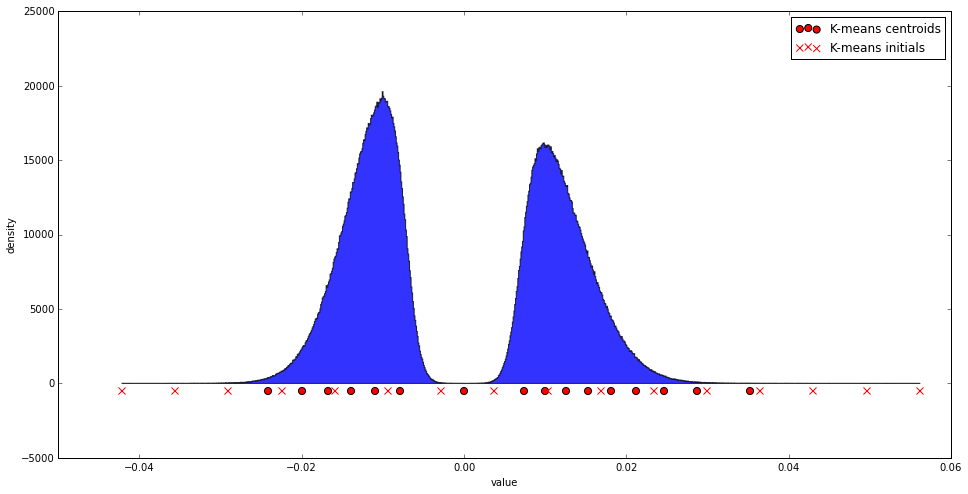

In [20]:
layers = ['fc6']
pp = PdfPages('distribution_of_codebook.pdf') 
for i,layer in enumerate(layers):
    W = net.params[layer][0].data   
    W = W[np.where(W!=0)] 
   
    numBins = 1024  
    code = codebook[layer]
    min_W = np.min(W)                                       
    max_W = np.max(W)                
    num_c = 2**np.ceil(np.log2(code.size))
    initial_uni = np.linspace(min_W, max_W, num_c) 
    print layer
    plt.figure(figsize=(16,8))    
    # std = np.std(W)
    plt.xlim(-0.05,0.06)
    plt.hist(W.flatten(), numBins, color='blue', alpha=0.8, histtype='stepfilled') 
    shift = 0.00015 * W.size
    code_dot=plt.scatter(code, np.zeros(code.shape)-shift, marker='o', c='red', s=50)
    initial_cross=plt.scatter(initial_uni, np.zeros(initial_uni.shape)-shift, marker='x', c='red', s=50)
    
    # 4std
    W = net.params[layer][0].data   
    W = W[np.where(W!=0)] 
      
    code = codebook_4std[layer]

    std = np.std(W)          
    num_c = 2**np.ceil(np.log2(code.size))
    initial_uni = np.linspace(std * -4, std * 4, num_c)  
      
    # std = np.std(W)
    # plt.hist(W.flatten(), numBins, color='blue', alpha=0.8) 
    #code_4std_dot=plt.scatter(code, np.zeros(code.shape)-2*shift, marker='o', c='green', s=50)
    #initial_4std_cross=plt.scatter(initial_uni, np.zeros(initial_uni.shape)-2*shift, marker='x', c='green', s=50)
    
    plt.legend([code_dot, initial_cross],# code_4std_dot, initial_4std_cross], 
               ['K-means centroids', 'K-means initials'])#, '4std codes', '4std initials'])
    plt.xlabel('value')
    plt.ylabel('density')
   
    plt.savefig(pp, format='pdf')
    pp.close()
    plt.show() 